<a href="https://colab.research.google.com/github/MiguelAngeloTr/BIGDATA/blob/main/C2/ProyectoFinal/Proyectofinal1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Estudiantes:

Miguel Angel Jimenez Trochez - 2215407
Juan Pablo Castaño  - 2215929
Christian David Cardenaz  - 2215689


In [1]:
!pip install -q pyspark
!pip install -q findspark
!pip install kagglehub[pandas-datasets]

In [2]:
import zipfile
import os, pathlib, PIL, shutil, glob
from google.colab import files

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.window as W
import pyspark.sql.types as T

import seaborn as sns
import matplotlib.pyplot as plt

from pandas.core.dtypes.api import is_numeric_dtype, is_string_dtype
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

from pyspark.ml.classification import LogisticRegression
from mlxtend.plotting import plot_confusion_matrix #falsos positivos falsos negativos
from mlxtend.evaluate import confusion_matrix
from yellowbrick.classifier import ROCAUC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bonangelrock","key":"799beae43c9c16dfa76c77a938f1711d"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d shantanugarg274/sales-dataset
!ls

Dataset URL: https://www.kaggle.com/datasets/shantanugarg274/sales-dataset
License(s): CC0-1.0
  0% 0.00/24.0k [00:00<?, ?B/s]
100% 24.0k/24.0k [00:00<00:00, 23.2MB/s]
kaggle.json  sales-dataset.zip	sample_data


In [6]:
zip_ref = zipfile.ZipFile('sales-dataset.zip', 'r') #localizar el nombre del archivo .zip y colocarlo
zip_ref.extractall('Data') #Extracción de archivos descargados en una carpeta llamada 'files', podria ser cualquier nombre
zip_ref.close()

In [7]:
spark = SparkSession.builder.appName("LogReg PySpark").getOrCreate()
spark

In [8]:
datos = spark.read.csv('/content/Data/Sales Dataset.csv',inferSchema=True, header=True)
datos.show(5, truncate=False)

+--------+------+------+--------+-----------+----------------+-----------+----------+-------------+--------+-------+-------------------+
|Order ID|Amount|Profit|Quantity|Category   |Sub-Category    |PaymentMode|Order Date|CustomerName |State   |City   |Year-Month         |
+--------+------+------+--------+-----------+----------------+-----------+----------+-------------+--------+-------+-------------------+
|B-26776 |9726  |1275  |5       |Electronics|Electronic Games|UPI        |2023-06-27|David Padilla|Florida |Miami  |2023-06-01 00:00:00|
|B-26776 |9726  |1275  |5       |Electronics|Electronic Games|UPI        |2024-12-27|Connor Morgan|Illinois|Chicago|2024-12-01 00:00:00|
|B-26776 |9726  |1275  |5       |Electronics|Electronic Games|UPI        |2021-07-25|Robert Stone |New York|Buffalo|2021-07-01 00:00:00|
|B-26776 |4975  |1330  |14      |Electronics|Printers        |UPI        |2023-06-27|David Padilla|Florida |Miami  |2023-06-01 00:00:00|
|B-26776 |4975  |1330  |14      |Electron

In [9]:
datos.printSchema()

root
 |-- Order ID: string (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Profit: integer (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- PaymentMode: string (nullable = true)
 |-- Order Date: date (nullable = true)
 |-- CustomerName: string (nullable = true)
 |-- State: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Year-Month: timestamp (nullable = true)



#Informacion Faltante y Columnas innecesarias


In [10]:
datos_f1 = datos.drop("Order ID")
datos_f1.show(10, truncate=False)

+------+------+--------+---------------+----------------+-----------+----------+--------------+----------+-----------+-------------------+
|Amount|Profit|Quantity|Category       |Sub-Category    |PaymentMode|Order Date|CustomerName  |State     |City       |Year-Month         |
+------+------+--------+---------------+----------------+-----------+----------+--------------+----------+-----------+-------------------+
|9726  |1275  |5       |Electronics    |Electronic Games|UPI        |2023-06-27|David Padilla |Florida   |Miami      |2023-06-01 00:00:00|
|9726  |1275  |5       |Electronics    |Electronic Games|UPI        |2024-12-27|Connor Morgan |Illinois  |Chicago    |2024-12-01 00:00:00|
|9726  |1275  |5       |Electronics    |Electronic Games|UPI        |2021-07-25|Robert Stone  |New York  |Buffalo    |2021-07-01 00:00:00|
|4975  |1330  |14      |Electronics    |Printers        |UPI        |2023-06-27|David Padilla |Florida   |Miami      |2023-06-01 00:00:00|
|4975  |1330  |14      |Ele

In [11]:
def faltantes(df):
  falta = df.select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in df.columns])
  return falta.show()

In [12]:
faltantes(datos_f1)

+------+------+--------+--------+------------+-----------+----------+------------+-----+----+----------+
|Amount|Profit|Quantity|Category|Sub-Category|PaymentMode|Order Date|CustomerName|State|City|Year-Month|
+------+------+--------+--------+------------+-----------+----------+------------+-----+----+----------+
|     0|     0|       0|       0|           0|          0|         0|           0|    0|   0|         0|
+------+------+--------+--------+------------+-----------+----------+------------+-----+----+----------+



# Analisis Exploratorio de Datos (EDA)

In [13]:
numeric_features = [t[0] for t in datos_f1.dtypes if t[1] == 'int' or t[1] == 'double']
datos_f1.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Amount,1194,5178.089614740368,2804.9219551878928,508,9992
Profit,1194,1348.9924623115578,1117.9925725296584,50,4930
Quantity,1194,10.674204355108877,5.777102059828169,1,20


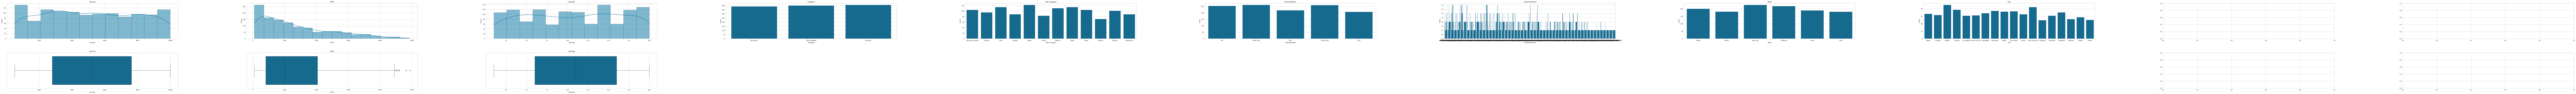

In [14]:
datos_EDA = datos_f1.toPandas()
num_list = []
cat_list = []

fig, axes = plt.subplots(2, len(datos_EDA.columns), figsize=(300, 10))  # Ajusta el tamaño según sea necesario
fig.subplots_adjust(hspace=0.4, wspace=0.4)

axes = axes.flatten()

# Contador para los gráficos
graph_count = 0

# Iterar sobre las columnas del DataFrame
for column in datos_EDA.columns:
    if is_numeric_dtype(datos_EDA[column]):
        # Histograma en la primera fila
        sns.histplot(datos_EDA[column], kde=True, ax=axes[graph_count])
        axes[graph_count].set_title(f"{column}")

        # Boxplot en la segunda fila
        sns.boxplot(x=datos_EDA[column], ax=axes[graph_count + len(datos_EDA.columns)])
        axes[graph_count + len(datos_EDA.columns)].set_title(f"{column}")
        num_list.append(column)
        graph_count += 1  # Pasar al siguiente gráfico

    elif is_string_dtype(datos_EDA[column]):
        sns.countplot(data=datos_EDA, x=datos_EDA[column], ax=axes[graph_count])
        axes[graph_count].set_title(f"{column}")
        cat_list.append(column)
        axes[graph_count + len(datos_EDA.columns)].axis("off")
        graph_count += 1  # Pasar al siguiente gráfico

# Mostrar la gráfica
plt.show()


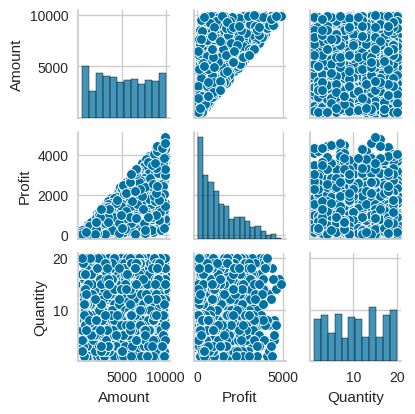

In [15]:
numeric_data = datos.select(numeric_features).toPandas()
sns.pairplot(numeric_data, height=1.4)
plt.show()

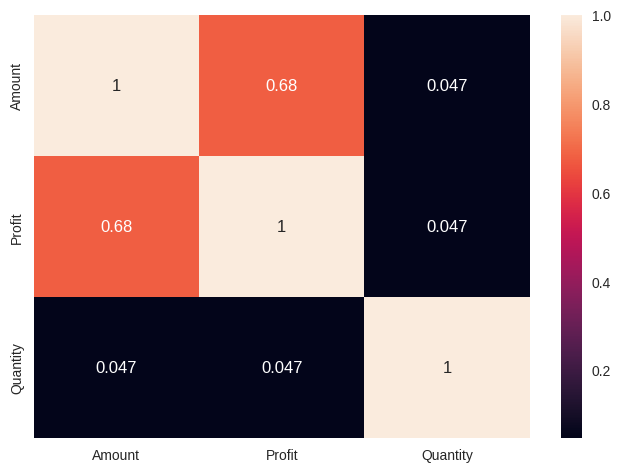

In [16]:
sns.heatmap(numeric_data.corr('spearman'),annot=True)
plt.show()

Es evidente que no hay variables numéricas altamente correlacionadas. Por lo tanto, las mantendremos todas para el modelo. Sin embargo, las columnas x no son realmente útiles, eliminaremos estas x columnas.

In [20]:
datos_f2 = datos_f1.select(
    'Order Date', 'City', 'State',
    'Category', 'Sub-Category', 'PaymentMode',
    'Quantity', 'Amount', 'Profit', 'Year-Month'
)

cols = datos_f2.columns
datos_f2.printSchema()




root
 |-- Order Date: date (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- PaymentMode: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Profit: integer (nullable = true)
 |-- Year-Month: timestamp (nullable = true)



In [18]:
salida = 'Profit'
caracteristicas = [car for car in cols if car not in salida]
cat = [c for c, t in datos_f2.dtypes if t == 'string' and c not in salida]
num = [c for c, t in datos_f2.dtypes if t in ['int', 'double'] and c not in salida]
print('Cat:',cat,'\nNum:', num)

Cat: ['City', 'State', 'Category', 'Sub-Category', 'PaymentMode'] 
Num: ['Quantity', 'Amount']


In [19]:
indexers = [StringIndexer(inputCol = col,
                          outputCol = "c_{}".format(col)) for col in cat]

encoders = [OneHotEncoder(inputCol = "c_{}".format(col),
                          outputCol = "o_{}".format(col)) for col in cat]

assembler = VectorAssembler(inputCols = num + ["o_{}".format(col) for col in cat], outputCol = "features")

labelIndexer = StringIndexer(inputCol=salida, outputCol='label') if salida in datos_f2.columns else None

preprocessor = Pipeline(stages = indexers + encoders + [assembler] + [labelIndexer]).fit(datos_f2)


#*Modelo 1*
